In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import cv2
import tensorflow as tf
from skimage.metrics import structural_similarity as ssim


In [2]:
def visualize_images(img, num_images=5):
    total_images = len(img)
    num_rows = int(np.ceil(total_images / num_images))  # 필요한 행의 수 계산
    
    # 서브플롯 생성 (num_rows 행과 num_images 열)
    fig, axes = plt.subplots(num_rows, num_images, figsize=(num_images * 3, num_rows * 3))
    
    # 만약 num_rows가 1이라면, axes를 1차원 배열로 처리하도록 설정
    if num_rows == 1:
        axes = np.expand_dims(axes, axis=0)
    
    # 이미지 그리기
    for i in range(total_images):
        row = i // num_images  # 현재 행
        col = i % num_images  # 현재 열
        axes[row, col].imshow(img[i].squeeze(), cmap='gray')  # 이미지 표시
        axes[row, col].set_title(f"Image {i+1}")  # 이미지 제목 설정
        axes[row, col].axis('off')  # 축 숨기기
    
    # 남은 빈 서브플롯 숨기기
    for i in range(total_images, num_rows * num_images):
        row = i // num_images
        col = i % num_images
        axes[row, col].axis('off')  # 빈 칸은 숨기기
    
    plt.tight_layout()
    plt.show()

FDC 데이터 불러오기

In [3]:
df_final = pd.read_csv('./data/fdc_data.csv')

정규화

In [4]:
scaler = StandardScaler()

sensor_data = df_final.iloc[:,5:]
sensor_data_scaled = scaler.fit_transform(sensor_data)
df_sensor_scaled = pd.DataFrame(sensor_data_scaled, columns=sensor_data.columns)
df_fdc_scaled = pd.concat([df_final.iloc[:,:5].reset_index(drop=True), df_sensor_scaled.reset_index(drop=True)], axis=1)

라벨 추출

In [5]:
labels = df_fdc_scaled['PASS(1)/FAIL(0)'].values
labels = np.array(labels)

이미지 데이터 불러오기

In [6]:
image_data = np.load('./data/image_data.npy')

모델

1. FDC data → Image 예측

2. Image → Scratch 분류

Train / Validation / Test

In [7]:
SEED = 42

In [8]:
fdc_train, fdc_temp, img_train, img_temp, labels_train, labels_temp = train_test_split(
    df_sensor_scaled, image_data, labels, test_size=0.2, random_state=SEED
)

fdc_val, fdc_test, img_val, img_test, labels_val, labels_test = train_test_split(
    fdc_temp, img_temp, labels_temp, test_size=0.25, random_state=SEED  # 0.25 of the remaining 20% = 5% of total
)

1. FDC data → Image 예측 모델

In [9]:
# # Encoder 모델: 입력 이미지를 잠재 공간으로 압축
# def build_encoder(input_dim):
#     model = tf.keras.Sequential()
#     model.add(layers.Dense(256, input_dim=input_dim))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
    
#     model.add(layers.Dense(512))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
    
#     model.add(layers.Dense(1024))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
    
#     model.add(layers.Dense(2048))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
    
#     # 잠재 공간 (저차원 공간) 출력
#     model.add(layers.Dense(64))  # 잠재 공간의 크기를 64로 설정
    
#     return model

# # Decoder 모델: 잠재 공간에서 128x128 이미지를 복원
# def build_decoder(latent_dim):
#     model = tf.keras.Sequential()
    
#     model.add(layers.Dense(2048))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
    
#     model.add(layers.Dense(1024, input_dim=latent_dim))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
    
#     model.add(layers.Dense(512))
#     model.add(layers.LeakyReLU(alpha=0.2))
    
#     model.add(layers.Dense(256))
#     model.add(layers.LeakyReLU(alpha=0.2))
    
#     # 128x128 이미지로 복원
#     model.add(layers.Dense(128 * 128, activation='sigmoid'))  # 이미지 픽셀 값이 0-1 범위이므로 sigmoid 사용
#     model.add(layers.Reshape((128, 128, 1)))
    
#     return model

# # Autoencoder 모델: Encoder와 Decoder를 연결
# def build_autoencoder(input_dim, latent_dim):
#     encoder = build_encoder(input_dim)
#     decoder = build_decoder(latent_dim)
    
#     inputs = layers.Input(shape=(input_dim,))
#     encoded = encoder(inputs)
#     decoded = decoder(encoded)
    
#     autoencoder = tf.keras.Model(inputs, decoded)
#     autoencoder.compile(optimizer='adam', loss='mse')  # Autoencoder에서는 MSE(평균 제곱 오차)를 사용
#     return autoencoder

# # 하이퍼파라미터
# tf.random.set_seed(SEED)
# input_dim = fdc_train.shape[1]  # FDC 데이터의 차원
# latent_dim = 64  # 잠재 공간의 크기
# epochs = 500
# batch_size = 32

# # 모델 빌드
# autoencoder = build_autoencoder(input_dim, latent_dim)

# # 학습 함수
# def train_autoencoder(epochs, batch_size):
#     autoencoder.fit(fdc_train, img_train, epochs=epochs, batch_size=batch_size, shuffle=True)

# # Autoencoder 학습 시작
# train_autoencoder(epochs, batch_size)

# # 모델 저장
# autoencoder.save('./data/model/autoencoder_model.keras')

In [10]:
autoencoder = tf.keras.models.load_model('./data/model/autoencoder_model.keras')

In [11]:
predicted_images = autoencoder.predict(fdc_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


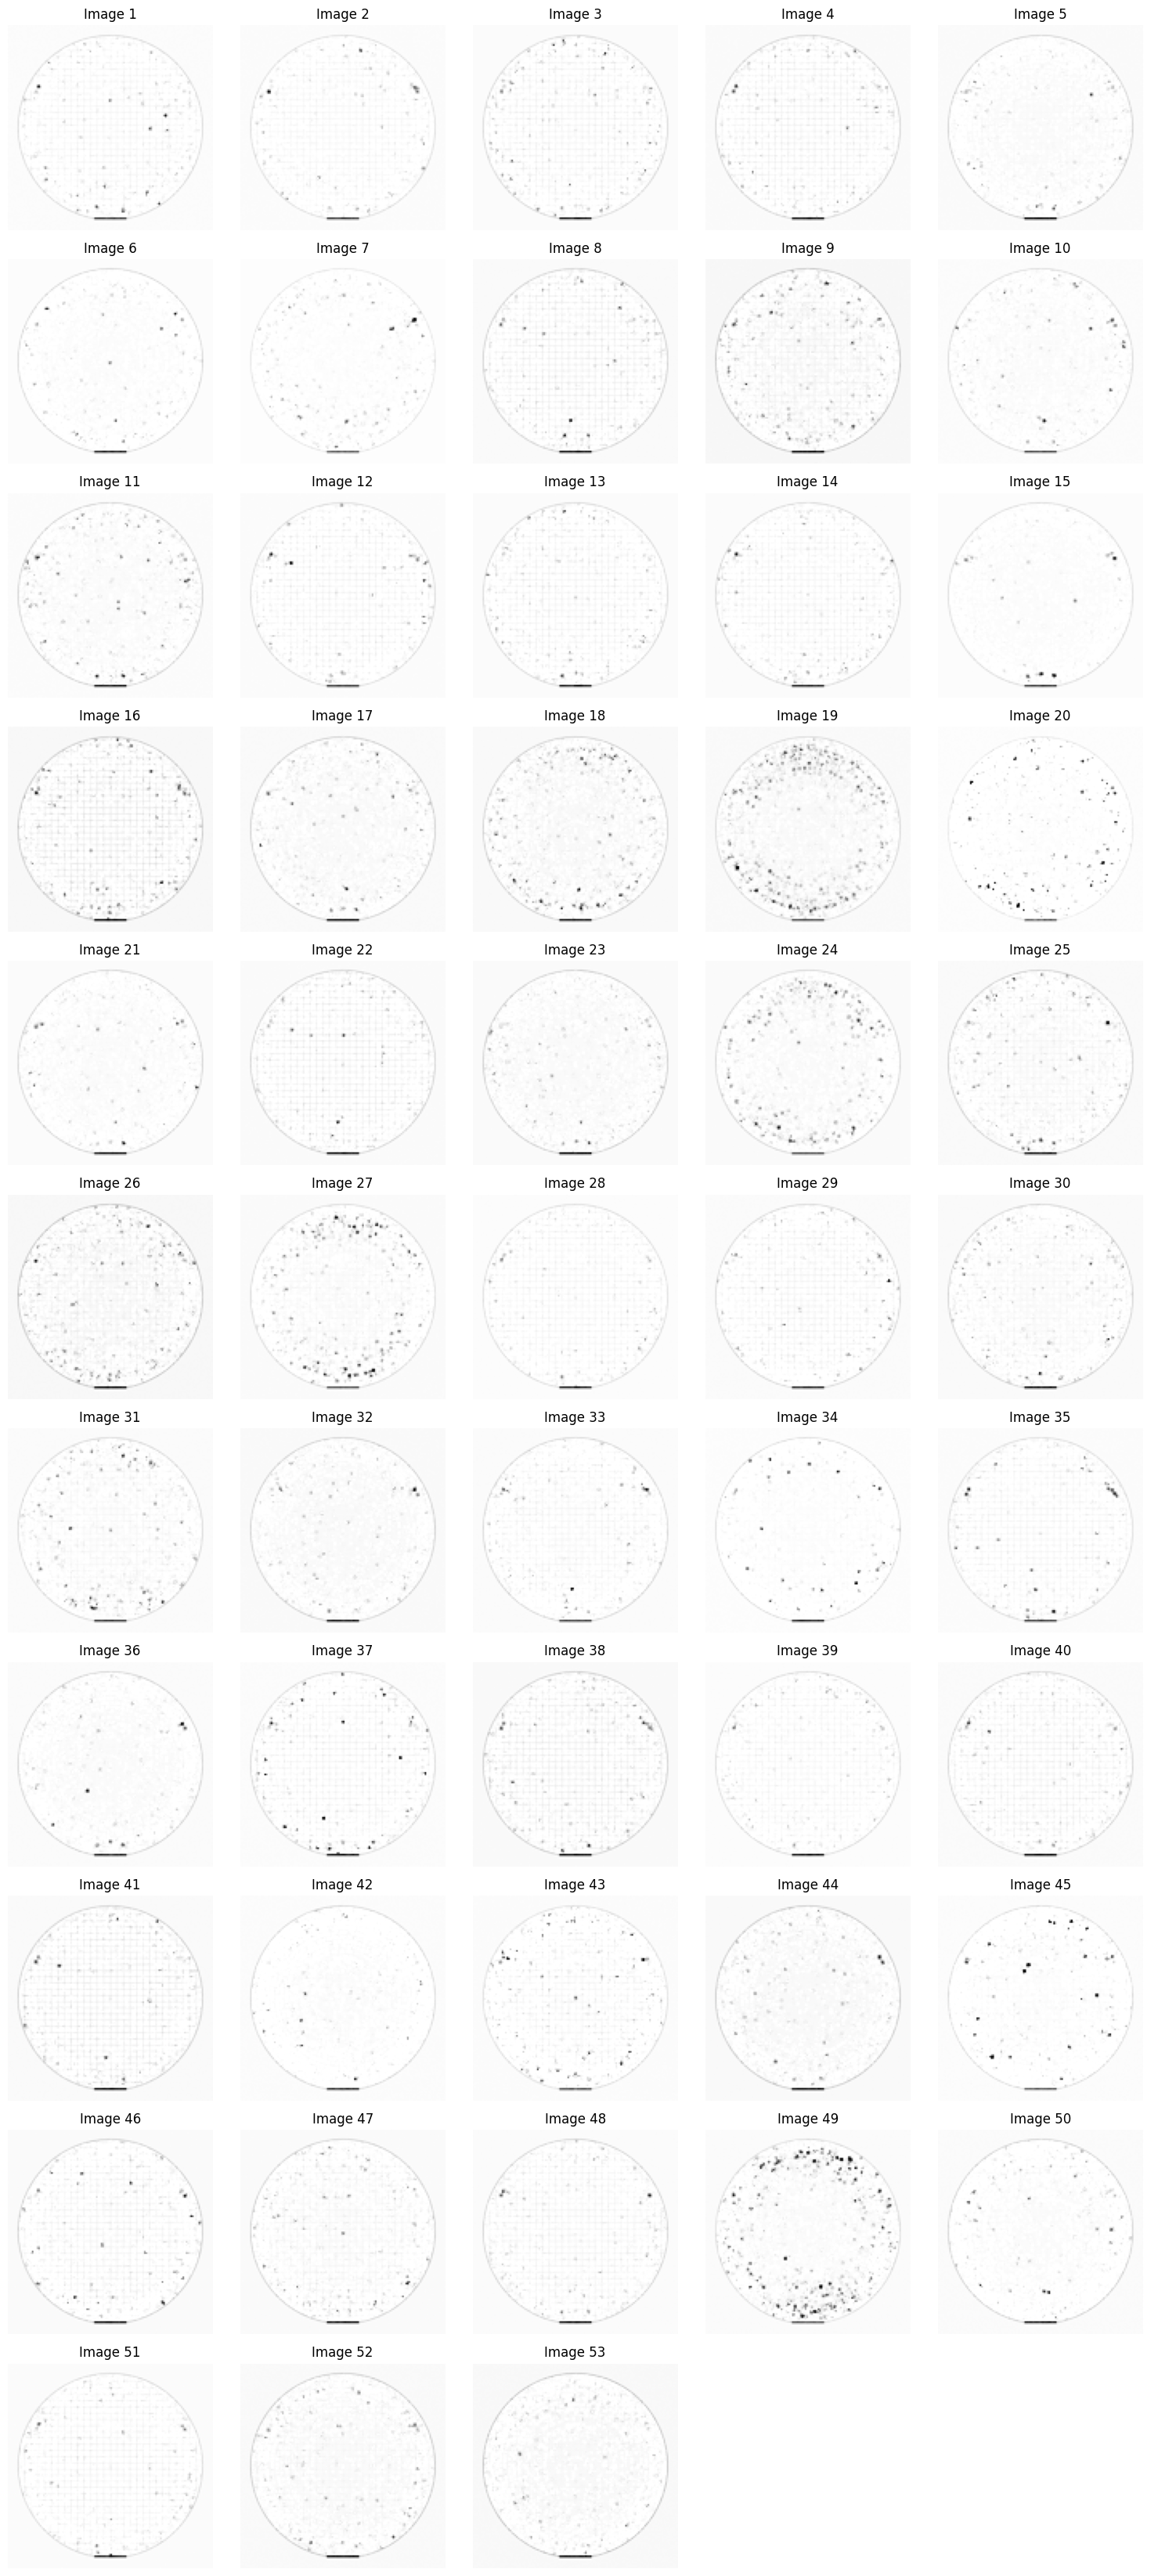

In [12]:
visualize_images(predicted_images)

In [15]:
# predicted_images에서 마지막 차원(채널) 제거
predicted_images_squeezed = np.squeeze(predicted_images)  # (53, 128, 128, 1) -> (53, 128, 128)

# 두 이미지 간의 SSIM 계산 (data_range 설정)
ssim_value = ssim(img_test, predicted_images_squeezed, multichannel=True, data_range=1)
print(f"SSIM: {ssim_value}")

SSIM: 0.6231750853089147


2. Image 분류 모델

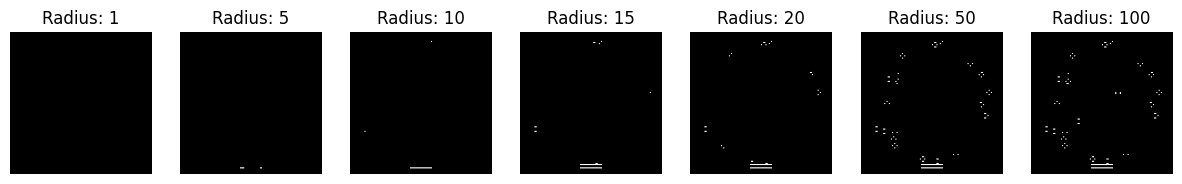

In [16]:
# 외곽 부분을 마스킹하는 함수 정의 (원형 마스크 사용)
def create_edge_mask(image, radius):
    h, w = image.shape[:2]
    center = (int(w / 2), int(h / 2))
    max_radius = min(center) - 2  # 이미지 경계 안에 들어가도록 반지름 설정
    mask = np.zeros((h, w), dtype=np.uint8)  # 마스크를 8비트 정수로 생성
    
    # 원형 마스크 생성 (두께는 외곽 영역의 범위를 조절)
    cv2.circle(mask, center, max_radius, 1, thickness=radius)  # 마스크 값 1로 설정
    return mask

# 이미지 데이터 (img_train을 불러온 상태라 가정)
image = img_train[0]  # 첫 번째 훈련 이미지 사용

# 다양한 radius 값으로 마스크를 생성하고 시각적으로 확인
radius_values = [1,5, 10, 15, 20, 50, 100]  # 다양한 반경 값을 설정
fig, axes = plt.subplots(1, len(radius_values), figsize=(15, 5))

for i, radius in enumerate(radius_values):
    # 마스크 생성
    mask = create_edge_mask(image, radius=radius)
    
    # 마스크를 이미지에 적용하여 시각적으로 비교
    masked_image = cv2.bitwise_and(image.squeeze().astype(np.uint8), image.squeeze().astype(np.uint8), mask=mask)
    
    # 이미지 출력
    axes[i].imshow(masked_image, cmap='gray')
    axes[i].set_title(f"Radius: {radius}")
    axes[i].axis('off')

plt.show()



In [17]:
# 외곽 부분을 마스킹하는 함수 정의 (원형 마스크 사용)
def create_edge_mask(image, radius=50):
    h, w = image.shape[:2]
    center = (int(w / 2), int(h / 2))
    max_radius = min(center) - 2  # 이미지 경계 안에 들어가도록 반지름 설정
    mask = np.zeros((h, w), dtype=np.uint8)  # 마스크를 uint8 형식으로 생성

    # 원형 마스크 생성 (두께는 외곽 영역의 범위를 조절)
    cv2.circle(mask, center, max_radius, 1, thickness=radius)  # 1로 채운 원형 마스크
    return mask

# 모든 이미지에 마스크 적용
def apply_mask_to_images(images, mask_radius=50):
    masked_images = []
    for image in images:
        mask = create_edge_mask(image.squeeze(), radius=mask_radius)
        
        # 이미지가 0~1로 스케일링된 경우 0~255 범위로 변환
        image_uint8 = (image.squeeze() * 255).astype(np.uint8)
        
        # 마스크 적용
        masked_image = cv2.bitwise_and(image_uint8, image_uint8, mask=mask)
        masked_images.append(masked_image)
    return np.array(masked_images)

# 훈련, 검증, 테스트 데이터 각각에 마스크 적용
masked_train = apply_mask_to_images(img_train)
masked_val = apply_mask_to_images(img_val)
masked_test = apply_mask_to_images(img_test)

In [18]:

# CNN 모델 생성
def build_edge_classification_model(input_shape):
    model = models.Sequential()
    
    # Convolutional layer로 특징 추출
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Flatten하여 Dense Layer에 연결
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    
    # 이진 분류를 위한 출력층
    model.add(layers.Dense(1, activation='sigmoid'))  # 이진 분류
    
    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# 입력 이미지의 크기 (128x128 크기의 흑백 이미지)
input_shape = (128, 128, 1)
model = build_edge_classification_model(input_shape)

# 모델 구조 확인
model.summary()


c:\Users\rkdeo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,193 (12.60 MB)

 Trainable params: 3,304,193 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# 훈련 데이터를 이용해 모델 학습
model.fit(masked_train, labels_train, 
          epochs=10, 
          batch_size=32, 
          validation_data=(masked_val, labels_val))

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - accuracy: 0.8273 - loss: 32.8414 - val_accuracy: 0.9434 - val_loss: 0.9948
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.9005 - loss: 0.4991 - val_accuracy: 0.9434 - val_loss: 0.4813
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.9760 - loss: 0.1289 - val_accuracy: 0.9434 - val_loss: 0.2125
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - accuracy: 0.9663 - loss: 0.1457 - val_accuracy: 0.9434 - val_loss: 0.2034
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - accuracy: 0.9720 - loss: 0.1214 - val_accuracy: 0.9434 - val_loss: 0.1892
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - accuracy: 0.9752 - loss: 0.1045 - val_accuracy: 0.9434 - val_loss: 0.1720
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - accuracy: 0.9696 - loss: 0.1143 - val_accuracy: 0.9434 - val_loss: 0.1735
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.9753 - loss: 0.0870 - val_accuracy: 0

In [20]:
# 테스트 데이터로 모델 성능 평가
test_loss, test_acc = model.evaluate(masked_test, labels_test)
print(f"테스트 정확도: {test_acc}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9310 - loss: 0.1563
테스트 정확도: 0.9433962106704712


In [21]:
masked_predicted_images = apply_mask_to_images(predicted_images)
predicted_loss, predicted_acc = model.evaluate(masked_predicted_images, labels_test)
print(f"테스트 정확도: {predicted_acc}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8850 - loss: 0.2847
테스트 정확도: 0.9056603908538818


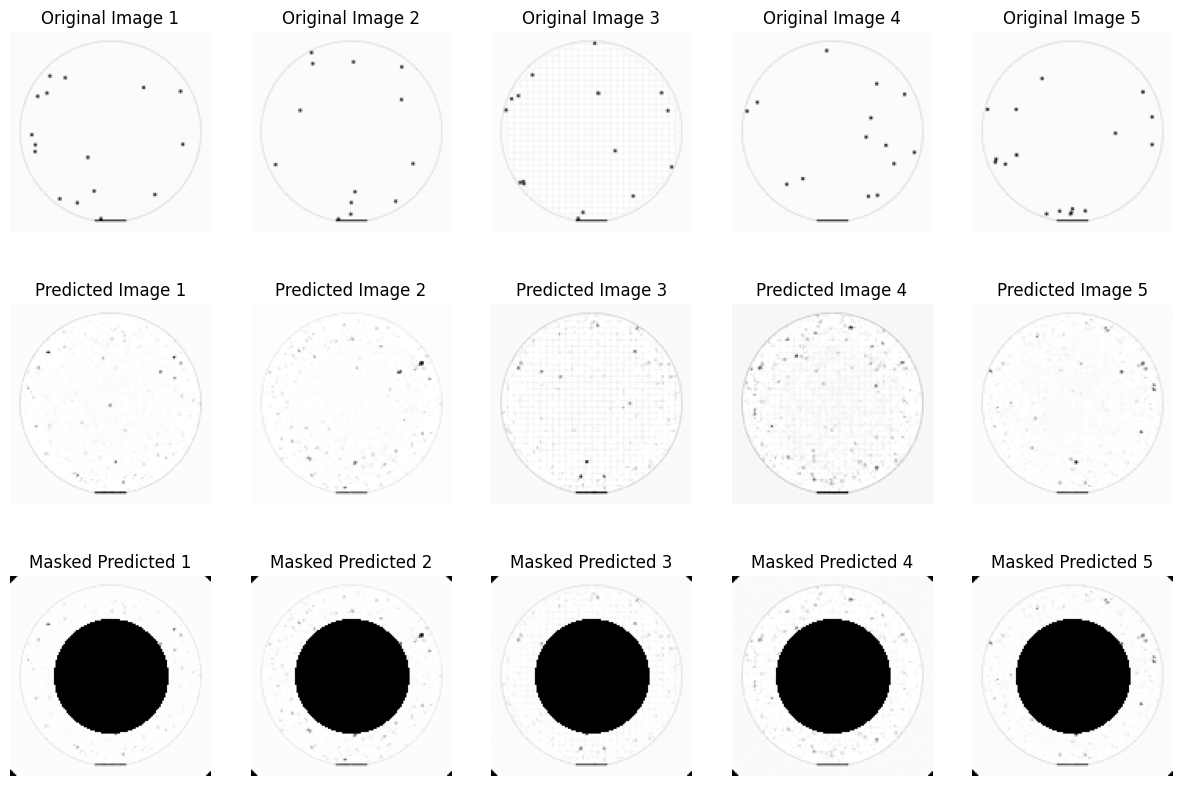

In [22]:
# 원본 이미지와 비교하여 시각적으로 평가
def compare_original_and_predicted(original_images, predicted_images, masked_images):
    fig, axes = plt.subplots(3, len(original_images), figsize=(15, 10))
    
    for i in range(len(original_images)):
        # 원본 이미지 출력
        axes[0, i].imshow(original_images[i].squeeze(), cmap='gray')
        axes[0, i].set_title(f"Original Image {i+1}")
        axes[0, i].axis('off')
        
        # 예측된 이미지 출력
        axes[1, i].imshow(predicted_images[i].squeeze(), cmap='gray')
        axes[1, i].set_title(f"Predicted Image {i+1}")
        axes[1, i].axis('off')
        
        # 마스크된 예측 이미지 출력
        axes[2, i].imshow(masked_images[i].squeeze(), cmap='gray')
        axes[2, i].set_title(f"Masked Predicted {i+1}")
        axes[2, i].axis('off')

    plt.show()

# 원본 이미지와 예측된 이미지를 비교
compare_original_and_predicted(img_test[5:10], predicted_images[5:10], masked_predicted_images[5:10])